# Andreev Multi Interferometer

In [1]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
from tqdm.notebook import tqdm

from qutils import thermal_broadening, sort_eigensystem

In [2]:
plt.style.use("plot_style.mplstyle")

In [3]:
m = 0.026         # Effective mass

L = 1000          # Lattice size (nm)
L_S = L//8*6       # Length of the Sc
L_N = L - L_S

mu_S = 10         # Chemical potential (meV)
mu_N = 10         # Chemical potential (meV)
Z = 0             # Barrier at the interface  (meV nm)

Delta_0 = 1   # Pairing potential (meV)

In [4]:
dir_name = f"./output/LS_{L_S:d}_LN_{L_N:d}_muS_{mu_S:d}_muN_{mu_N:d}_Delta_{Delta_0:d}/"

In [5]:
os.makedirs(dir_name, exist_ok=True)

In [6]:
Nx = L//4       # Number of points for the numerical problem

x = np.linspace(0, L, Nx, endpoint=False)
dx = x[1] - x[0]
t = (38.1 / m) / dx**2

In [7]:
print(t)

91.58653846153847


In [8]:
xi = (2 * np.sqrt(mu_S * t)/(np.pi * Delta_0)) * dx
print(xi)
print(L_S/xi)

77.06477891281882
9.732072297884011


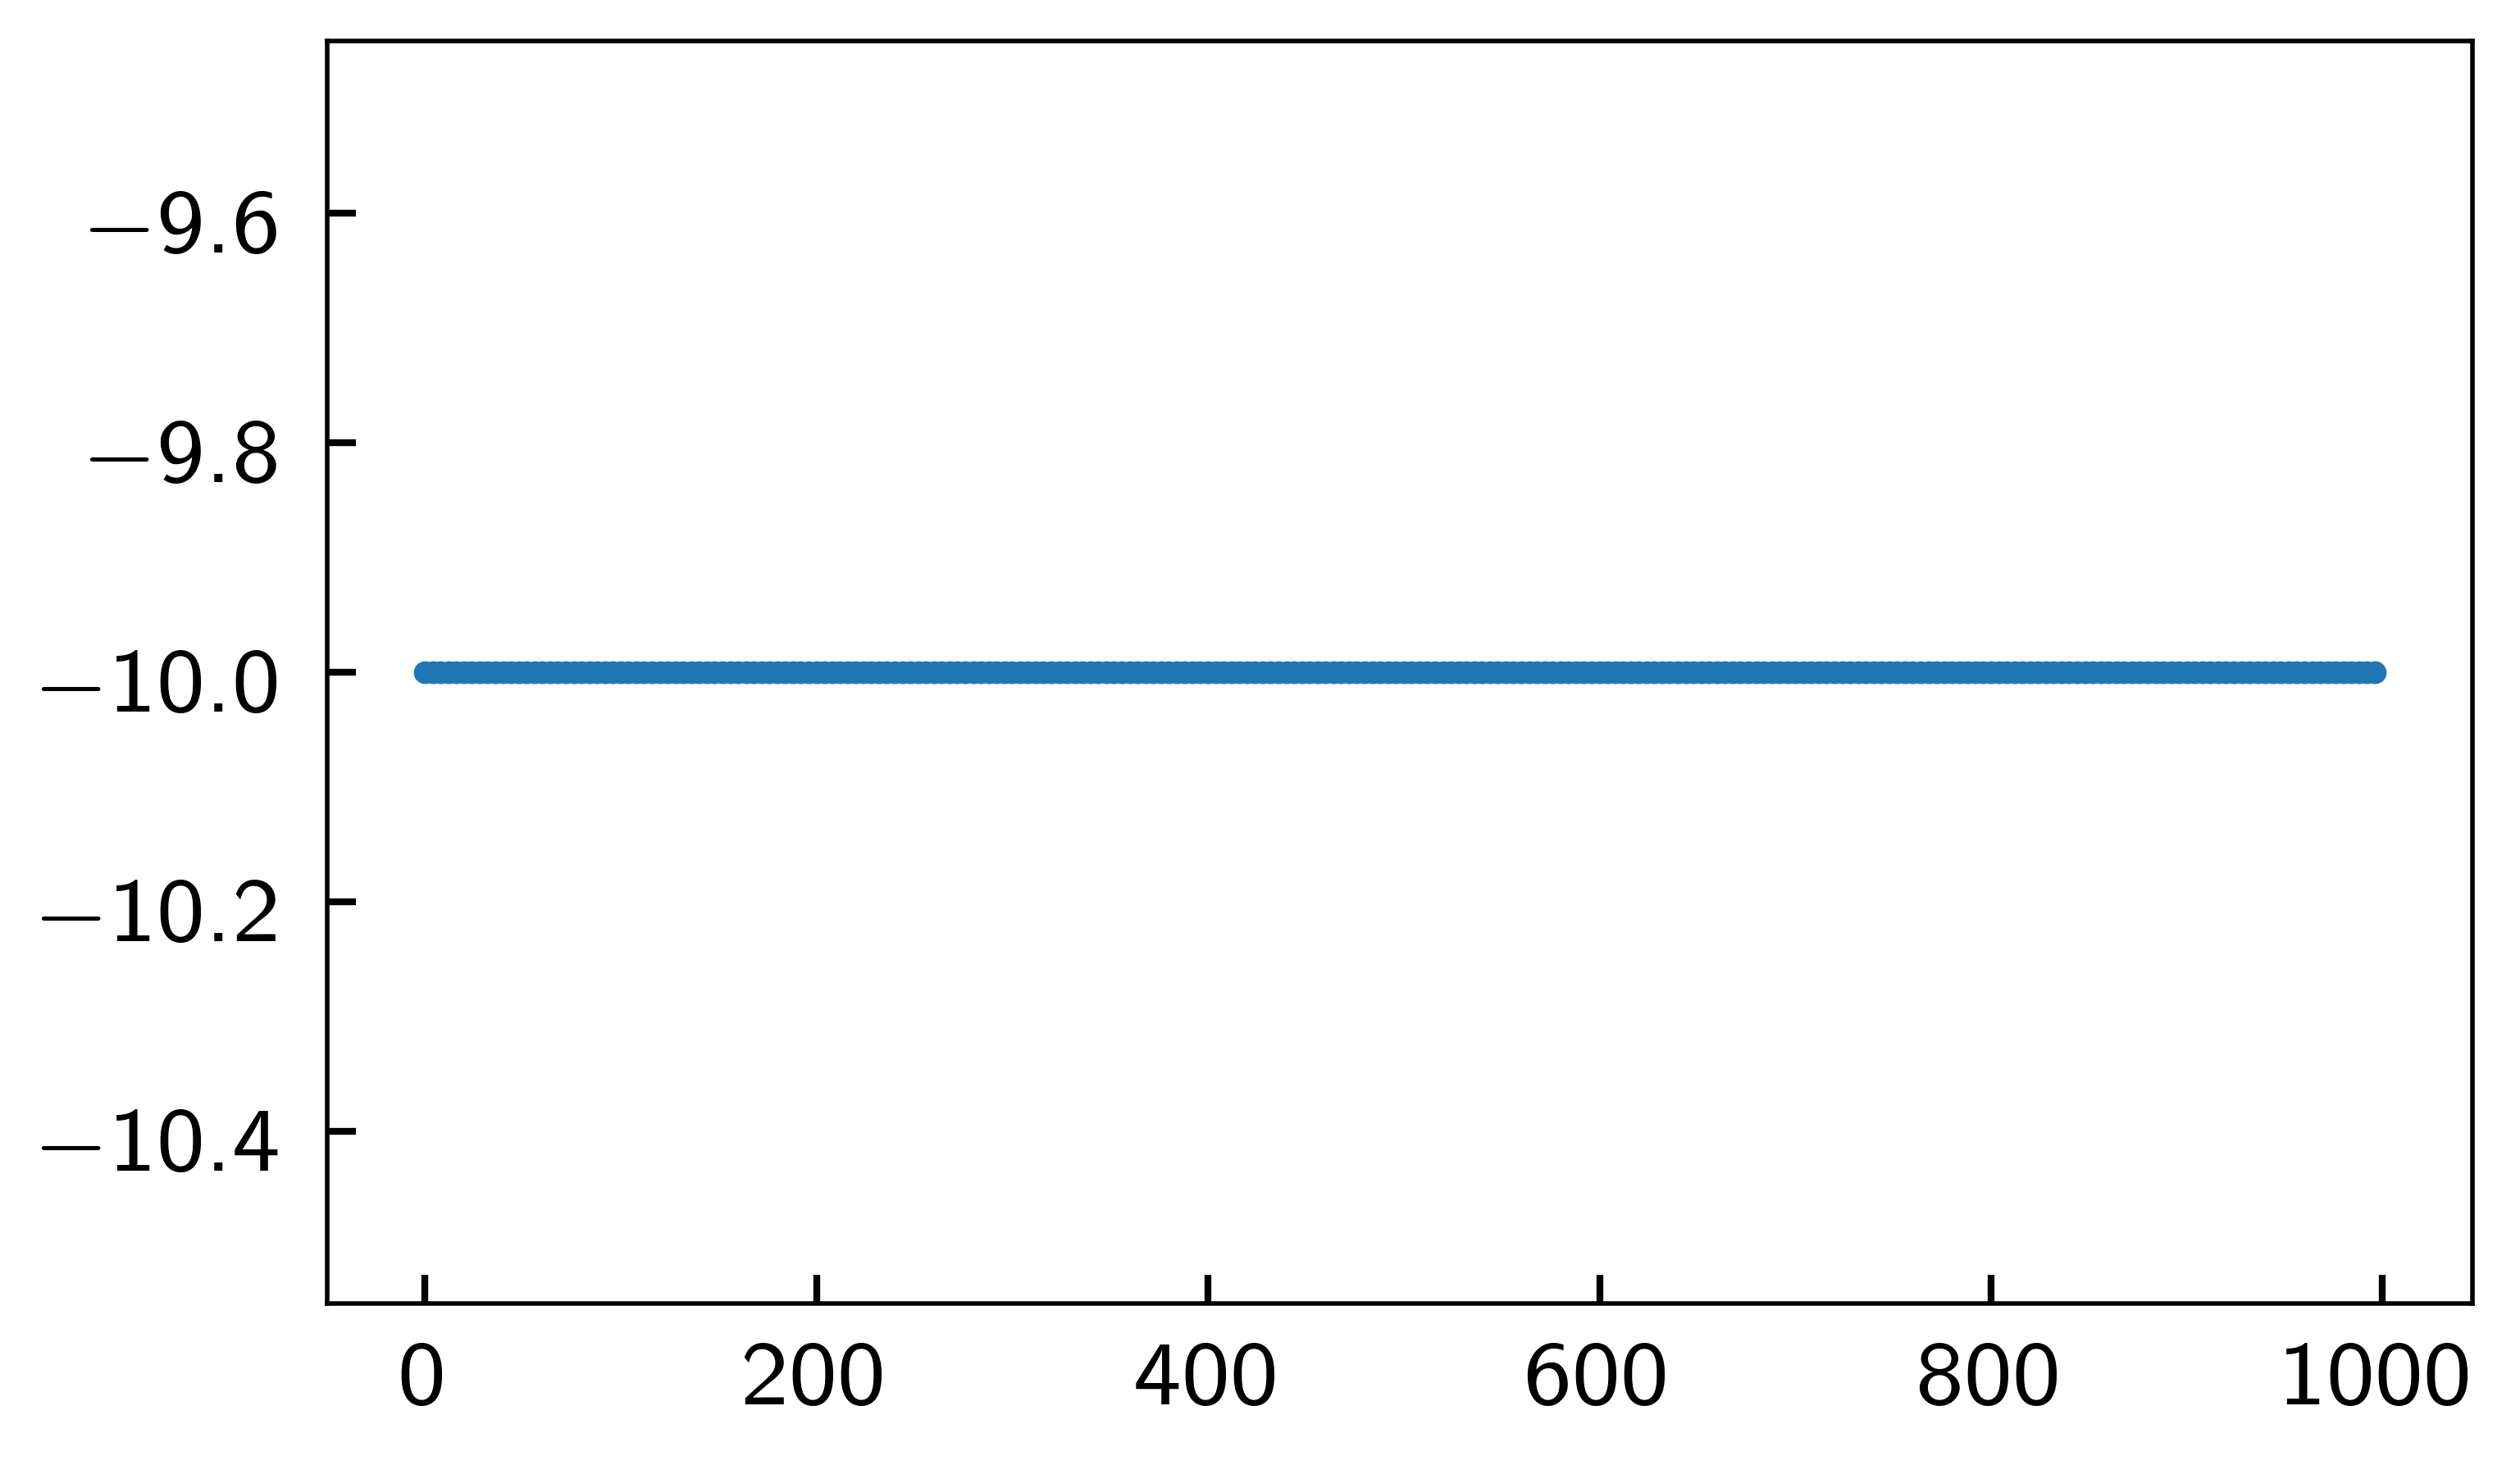

In [9]:
V = np.zeros((Nx))

V[x<=L_S] += -mu_S
V[x>L_S] += -mu_N

V[abs(x-L_S) < dx] += Z/dx
V[abs(x) < dx] += Z/dx

plt.plot(x, V)

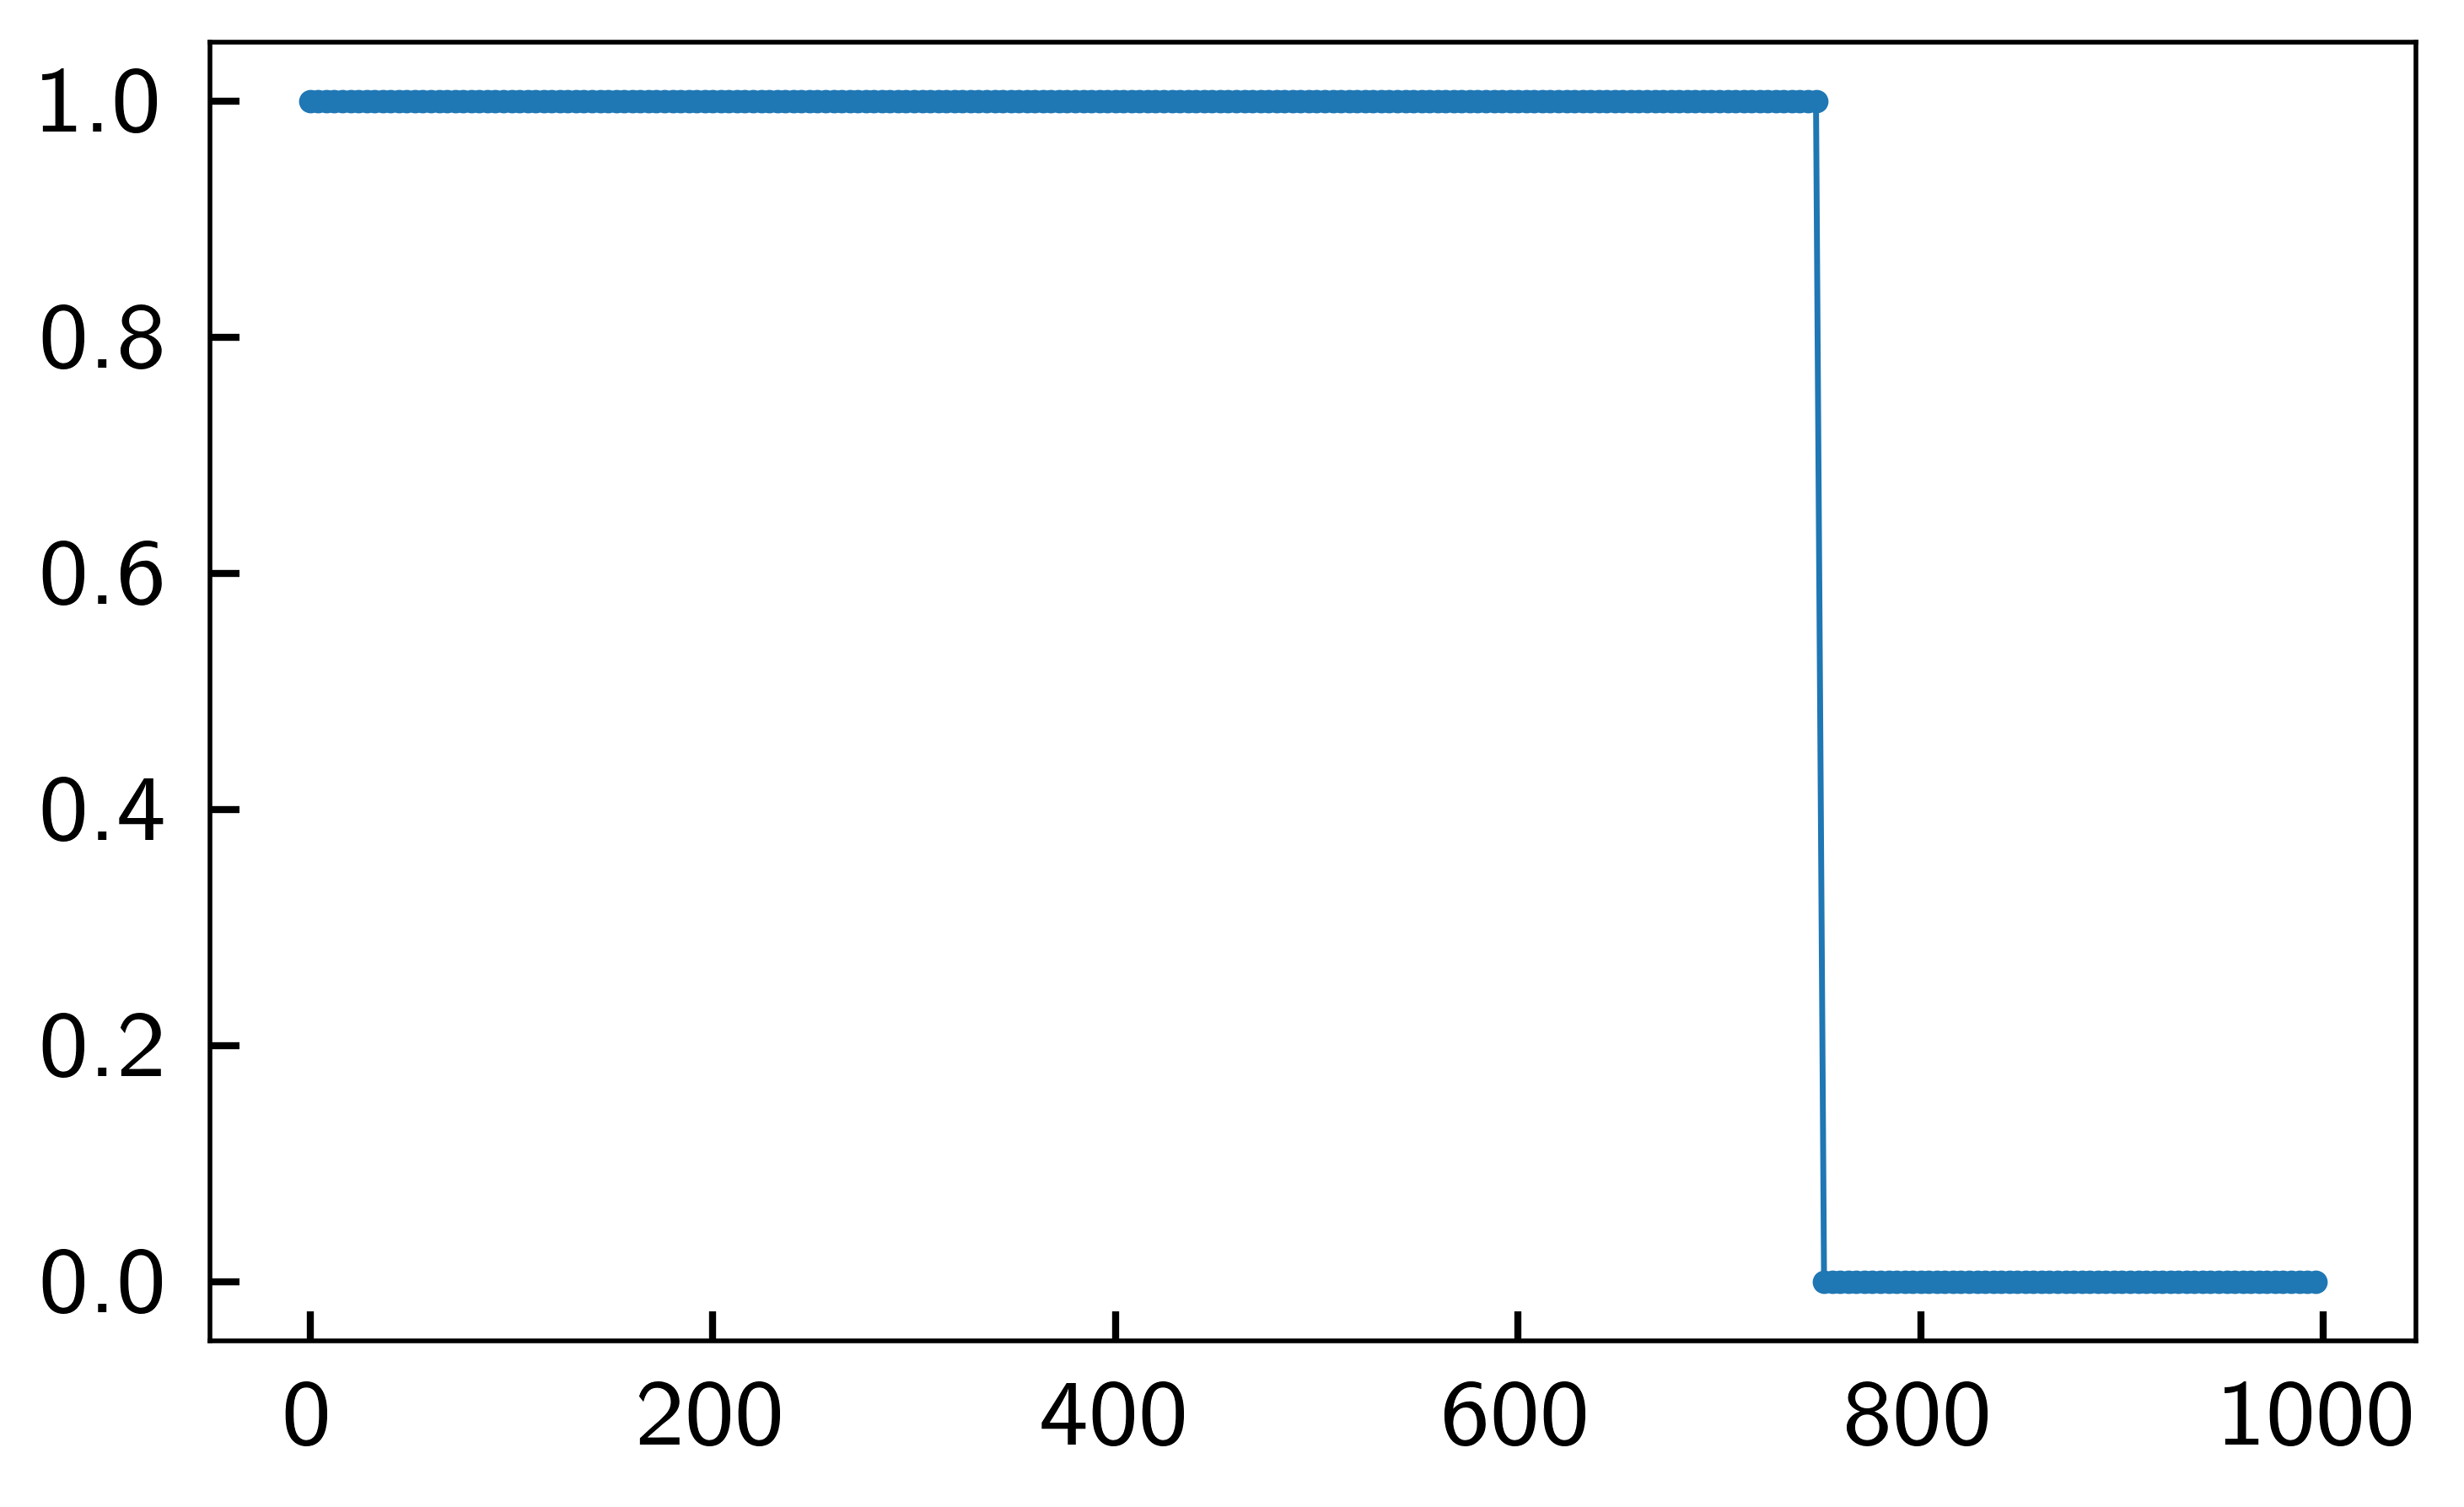

In [10]:
Delta = np.zeros((Nx))
Delta[x < L_S] = Delta_0
plt.plot(x, Delta)

In [11]:
def make_H(k, dphi, Nx, t, V, Delta, q): 
    H = np.zeros((2 * Nx, 2 * Nx), dtype=complex) 
    
    H_e = np.zeros((Nx, Nx), dtype=complex)
    H_e += np.diag(np.ones(Nx), 0) * (2 * t) 
    H_e += np.diag(np.ones(Nx-1), +1) * (- t) * np.exp(- 1j * q)
    H_e += np.diag(np.ones(Nx-1), -1) * (- t) * np.exp(+ 1j * q)
    H_e[0, -1] = -t  * np.exp(- 1j * q - 1j * k * L - 1j * dphi / 2)
    H_e[-1, 0] = -t  * np.exp(+ 1j * q + 1j * k * L + 1j * dphi / 2)
    H_e += np.diag(V)

    H_h = np.zeros((Nx, Nx), dtype=complex)
    H_h += np.diag(np.ones(Nx), 0) * (- 2 * t)
    H_h += np.diag(np.ones(Nx-1), +1) * (+ t) * np.exp(+ 1j * q)
    H_h += np.diag(np.ones(Nx-1), -1) * (+ t) * np.exp(- 1j * q)
    H_h[0, -1] = ( + t)  * np.exp(+ 1j * q - 1j * k * L + 1j * dphi / 2)
    H_h[-1, 0] = ( + t)  * np.exp(- 1j * q + 1j * k * L - 1j * dphi / 2)
    H_h += -np.diag(V)

    H += np.kron(H_e, [[1, 0], 
                       [0, 0]])
    H += np.kron(H_h, [[0, 0], 
                       [0, 1]])

    H_s = np.diag(Delta)
    H += np.kron(H_s, [[+0, +1], 
                       [+1, +0]])
    
    return H

In [12]:
H_test = make_H(0.25, 0.35, Nx, t, V, Delta, q=0)
assert(not np.any(H_test - H_test.T.conj()))

In [13]:
make_H_bind = partial(make_H, Nx=Nx, t=t, V=V, Delta=Delta, q=0)

In [14]:
k_N = 50
k_ax = np.linspace(-np.pi/L, np.pi/L, k_N)
dk = k_ax[1] - k_ax[0]

phi_N = 9
phi_ax = np.linspace(0, 4*np.pi, phi_N)

k, phi = np.meshgrid(k_ax, phi_ax)

In [15]:
ws = np.zeros((k_N, phi_N, 2*Nx))
vs = np.zeros((k_N, phi_N, 2*Nx, 2*Nx), dtype=complex)

for i, k in tqdm(enumerate(k_ax), total=k_N):
    for j, phi in enumerate(phi_ax):
        ws[i, j], vs[i, j] = la.eigh(make_H_bind(k, phi))

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
for j in tqdm(range(phi_N)):
        ws[:,j] , vs[:, j] = sort_eigensystem(ws[:,j] , vs[:, j])

  0%|          | 0/9 [00:00<?, ?it/s]

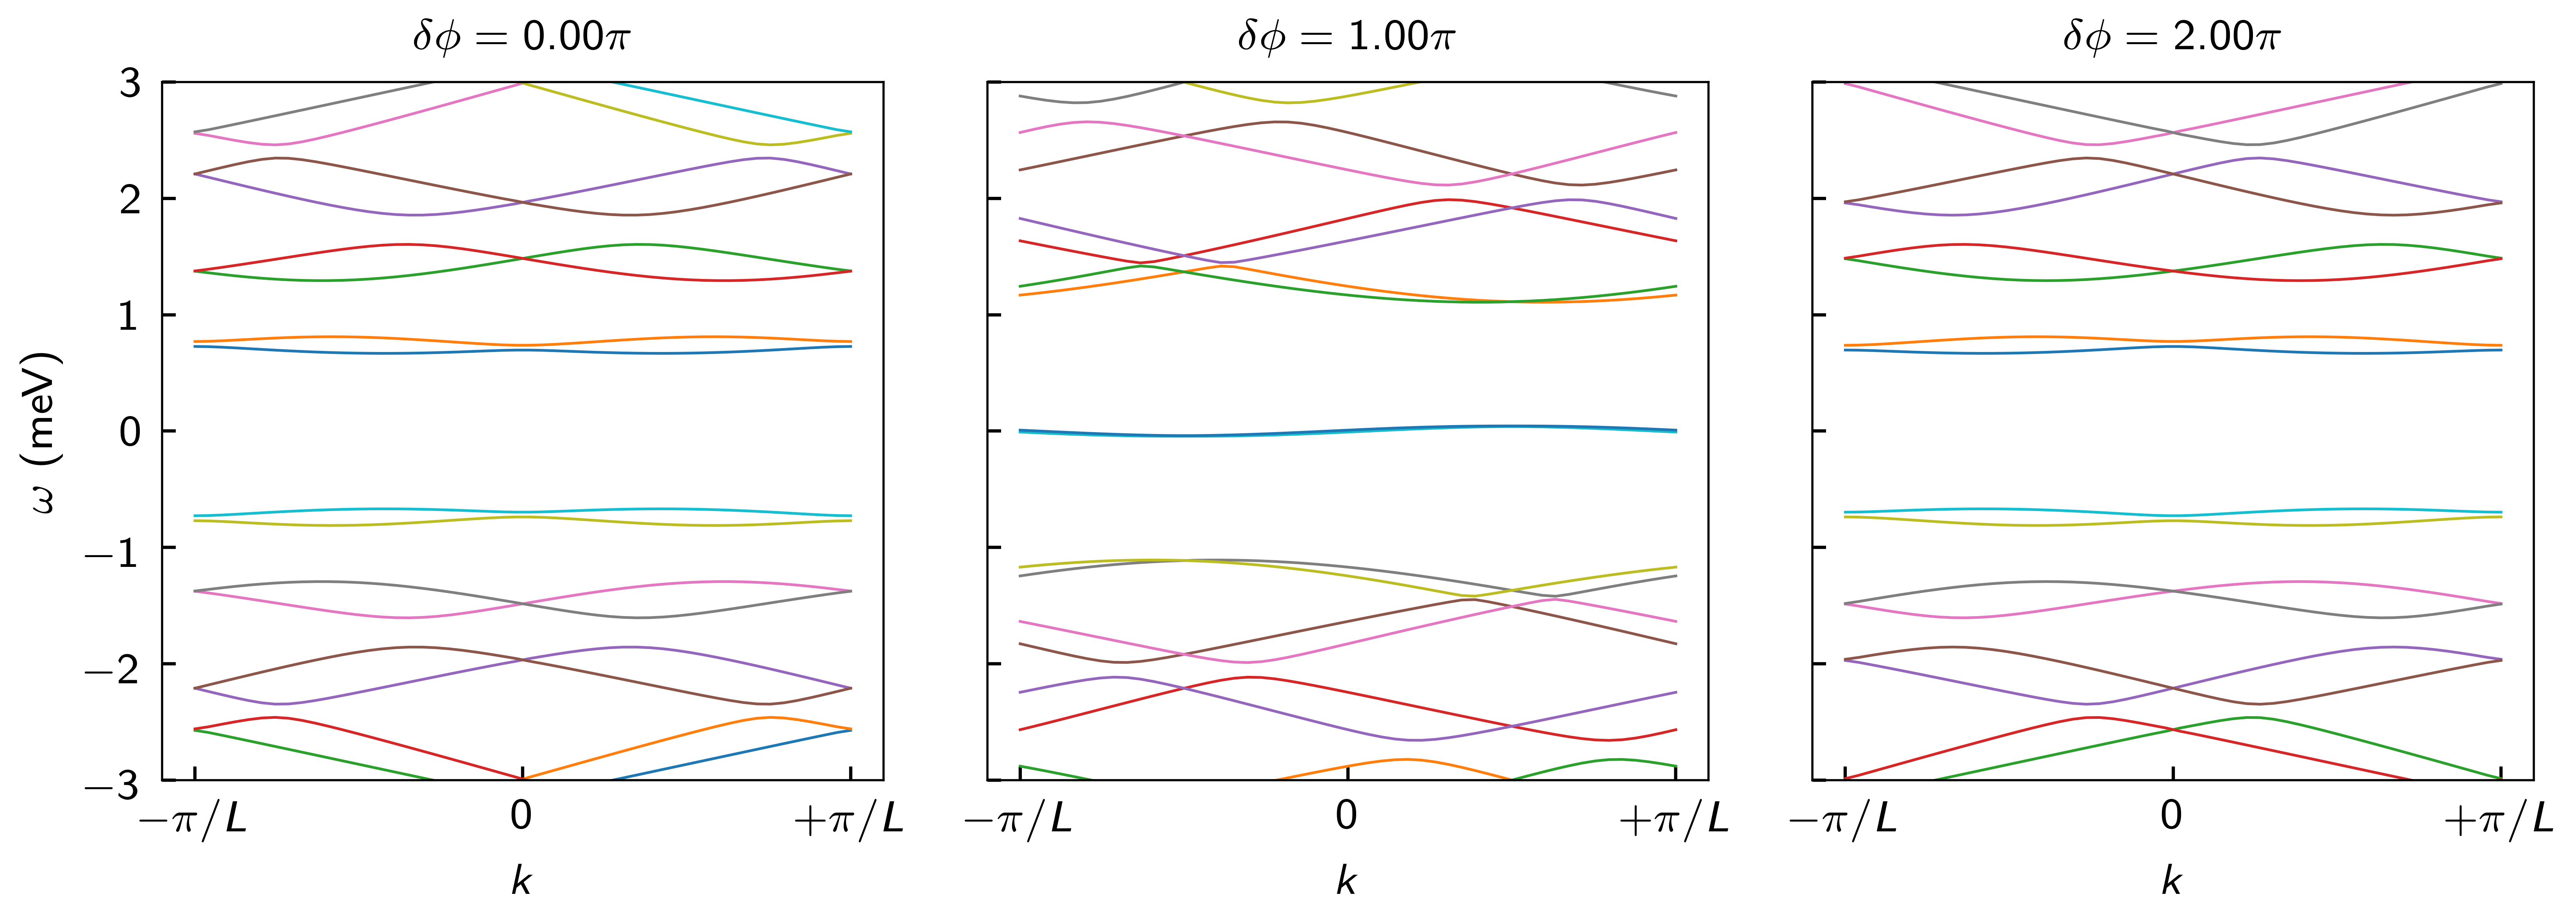

In [17]:
phi_idxs = [0, phi_N//4, phi_N//2]

fig, axs = plt.subplots(ncols=3, figsize = (2*3.375, 2.5), sharey=True)

for i, ax in enumerate(axs): 
    axs[i].plot(k_ax, ws[:, phi_idxs[i]]/Delta_0, '-');
    axs[i].set_ylim(np.array([-3, 3]))
    axs[i].set_xlabel(r"$k$")
    axs[i].set_xticks([k_ax.min(), 0, k_ax.max()], [r"$-\pi/L$", r"$0$", r"$+\pi/L$"])
    axs[i].set_title(rf"$\delta \phi = {(phi_ax[phi_idxs[i]]/np.pi):3.2f} \pi$")

axs[0].set_ylabel(r"$\omega$ (meV)")
fig.tight_layout()

fig.savefig(dir_name+"bands_k.png")

In [18]:
k_N = 3
k_ax = np.linspace(-np.pi/L, np.pi/L, k_N)

phi_N = 100
phi_ax = np.linspace(0, 4*np.pi, phi_N)

k, phi = np.meshgrid(k_ax, phi_ax)

In [19]:
ws = np.zeros((k_N, phi_N, 2*Nx))
vs = np.zeros((k_N, phi_N, 2*Nx, 2*Nx), dtype=complex)

for i, k in tqdm(enumerate(k_ax), total=k_N):
    for j, phi in enumerate(phi_ax):
        ws[i, j], vs[i, j] = la.eigh(make_H_bind(k, phi))

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
for i in tqdm(range(k_N)):
        ws[i] , vs[i] = sort_eigensystem(ws[i] , vs[i])

  0%|          | 0/3 [00:00<?, ?it/s]

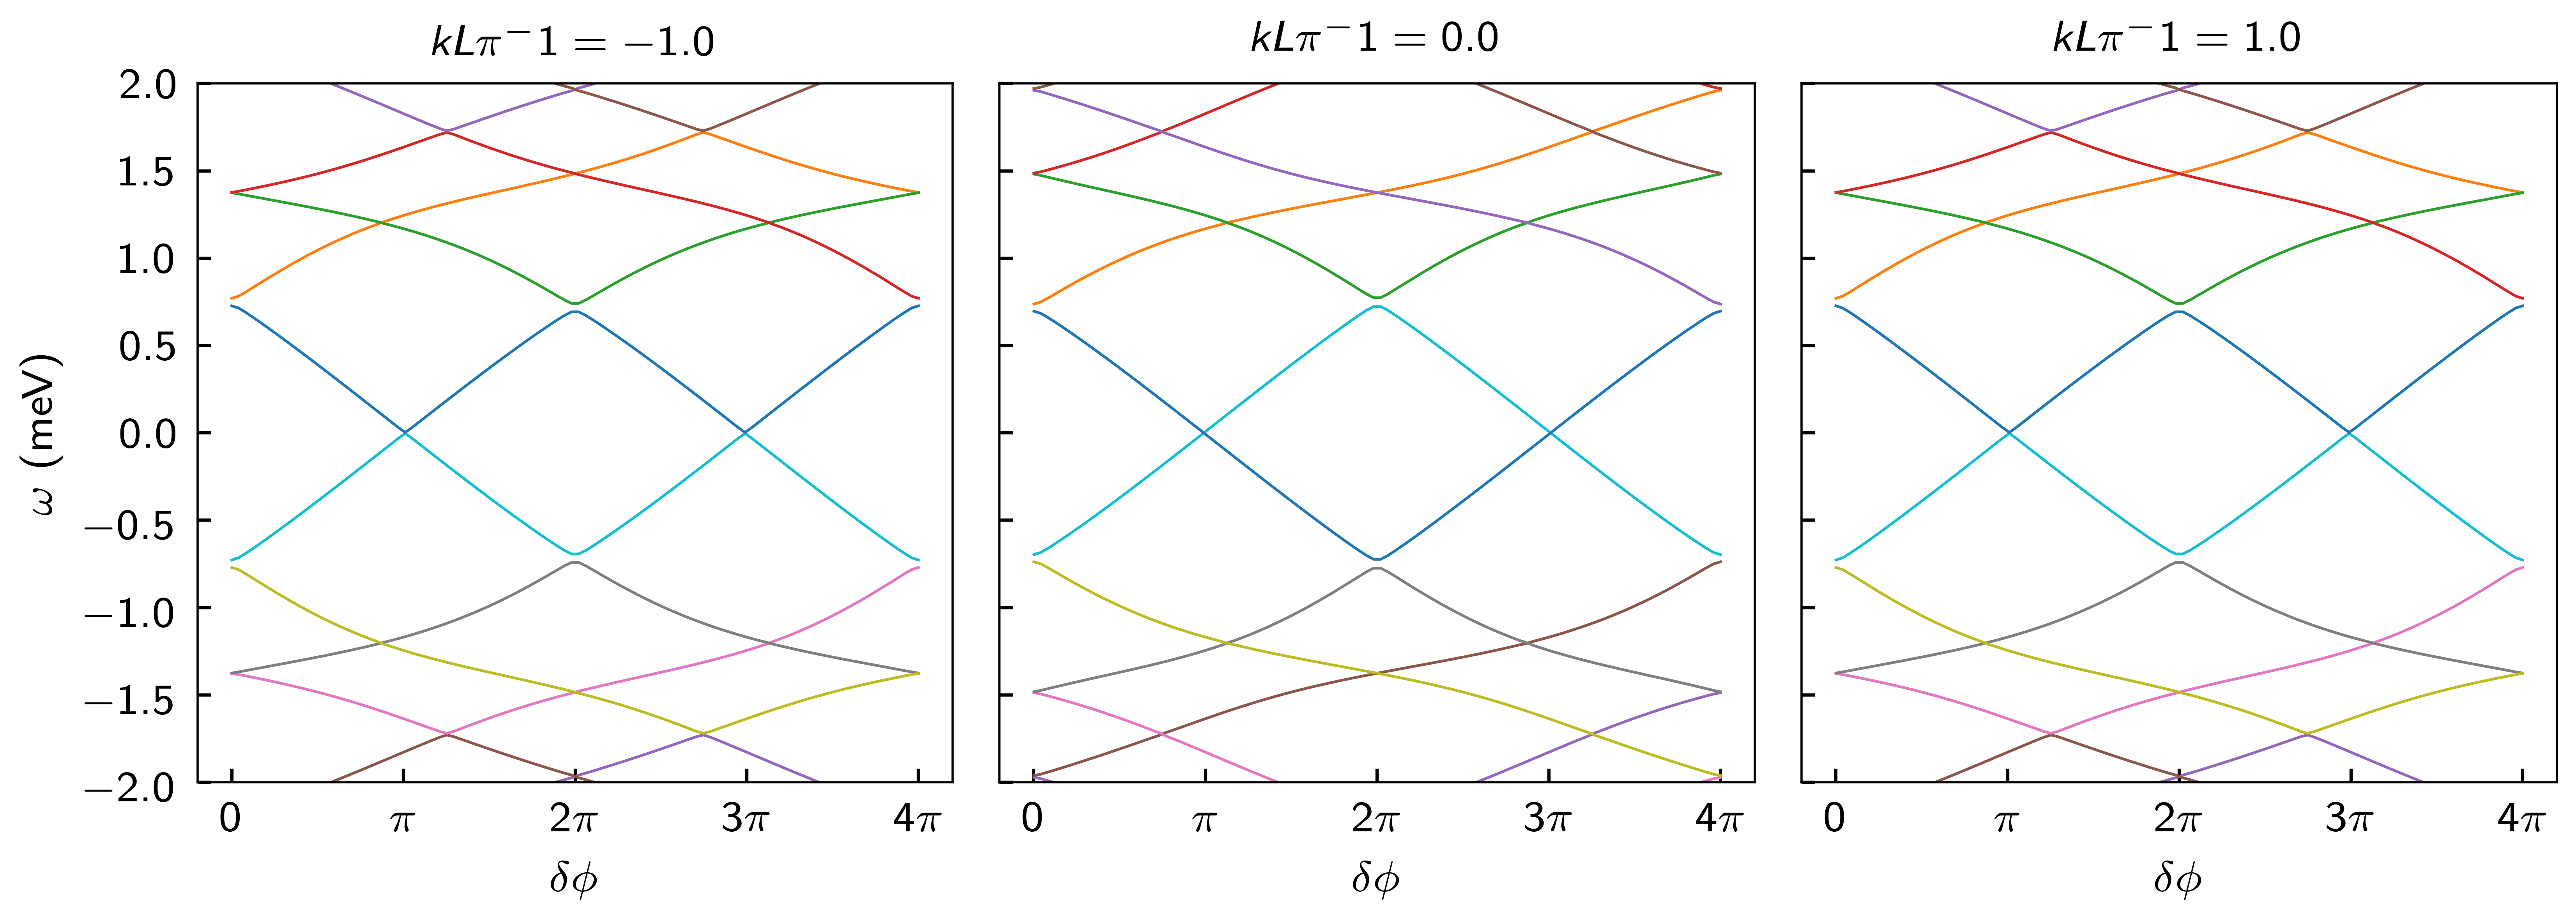

In [21]:
k_idx = [0, 1, 2]

fig, axs = plt.subplots(ncols=3, figsize = (2*3.375, 2.5), sharey=True)

for i, ax in enumerate(axs): 
    ax.plot(phi_ax, ws[k_idx[i], :], '-');
    ax.set_ylim(-2, 2)
    ax.set_xlabel(r"$\delta \phi$")
    ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
    ax.set_title(rf"$k L \pi^{-1} = {L/np.pi*k_ax[k_idx[i]]:2.1f}$")

axs[0].set_ylabel(r"$\omega$ (meV)")

fig.tight_layout()
fig.savefig(dir_name+"bands_phi.png")

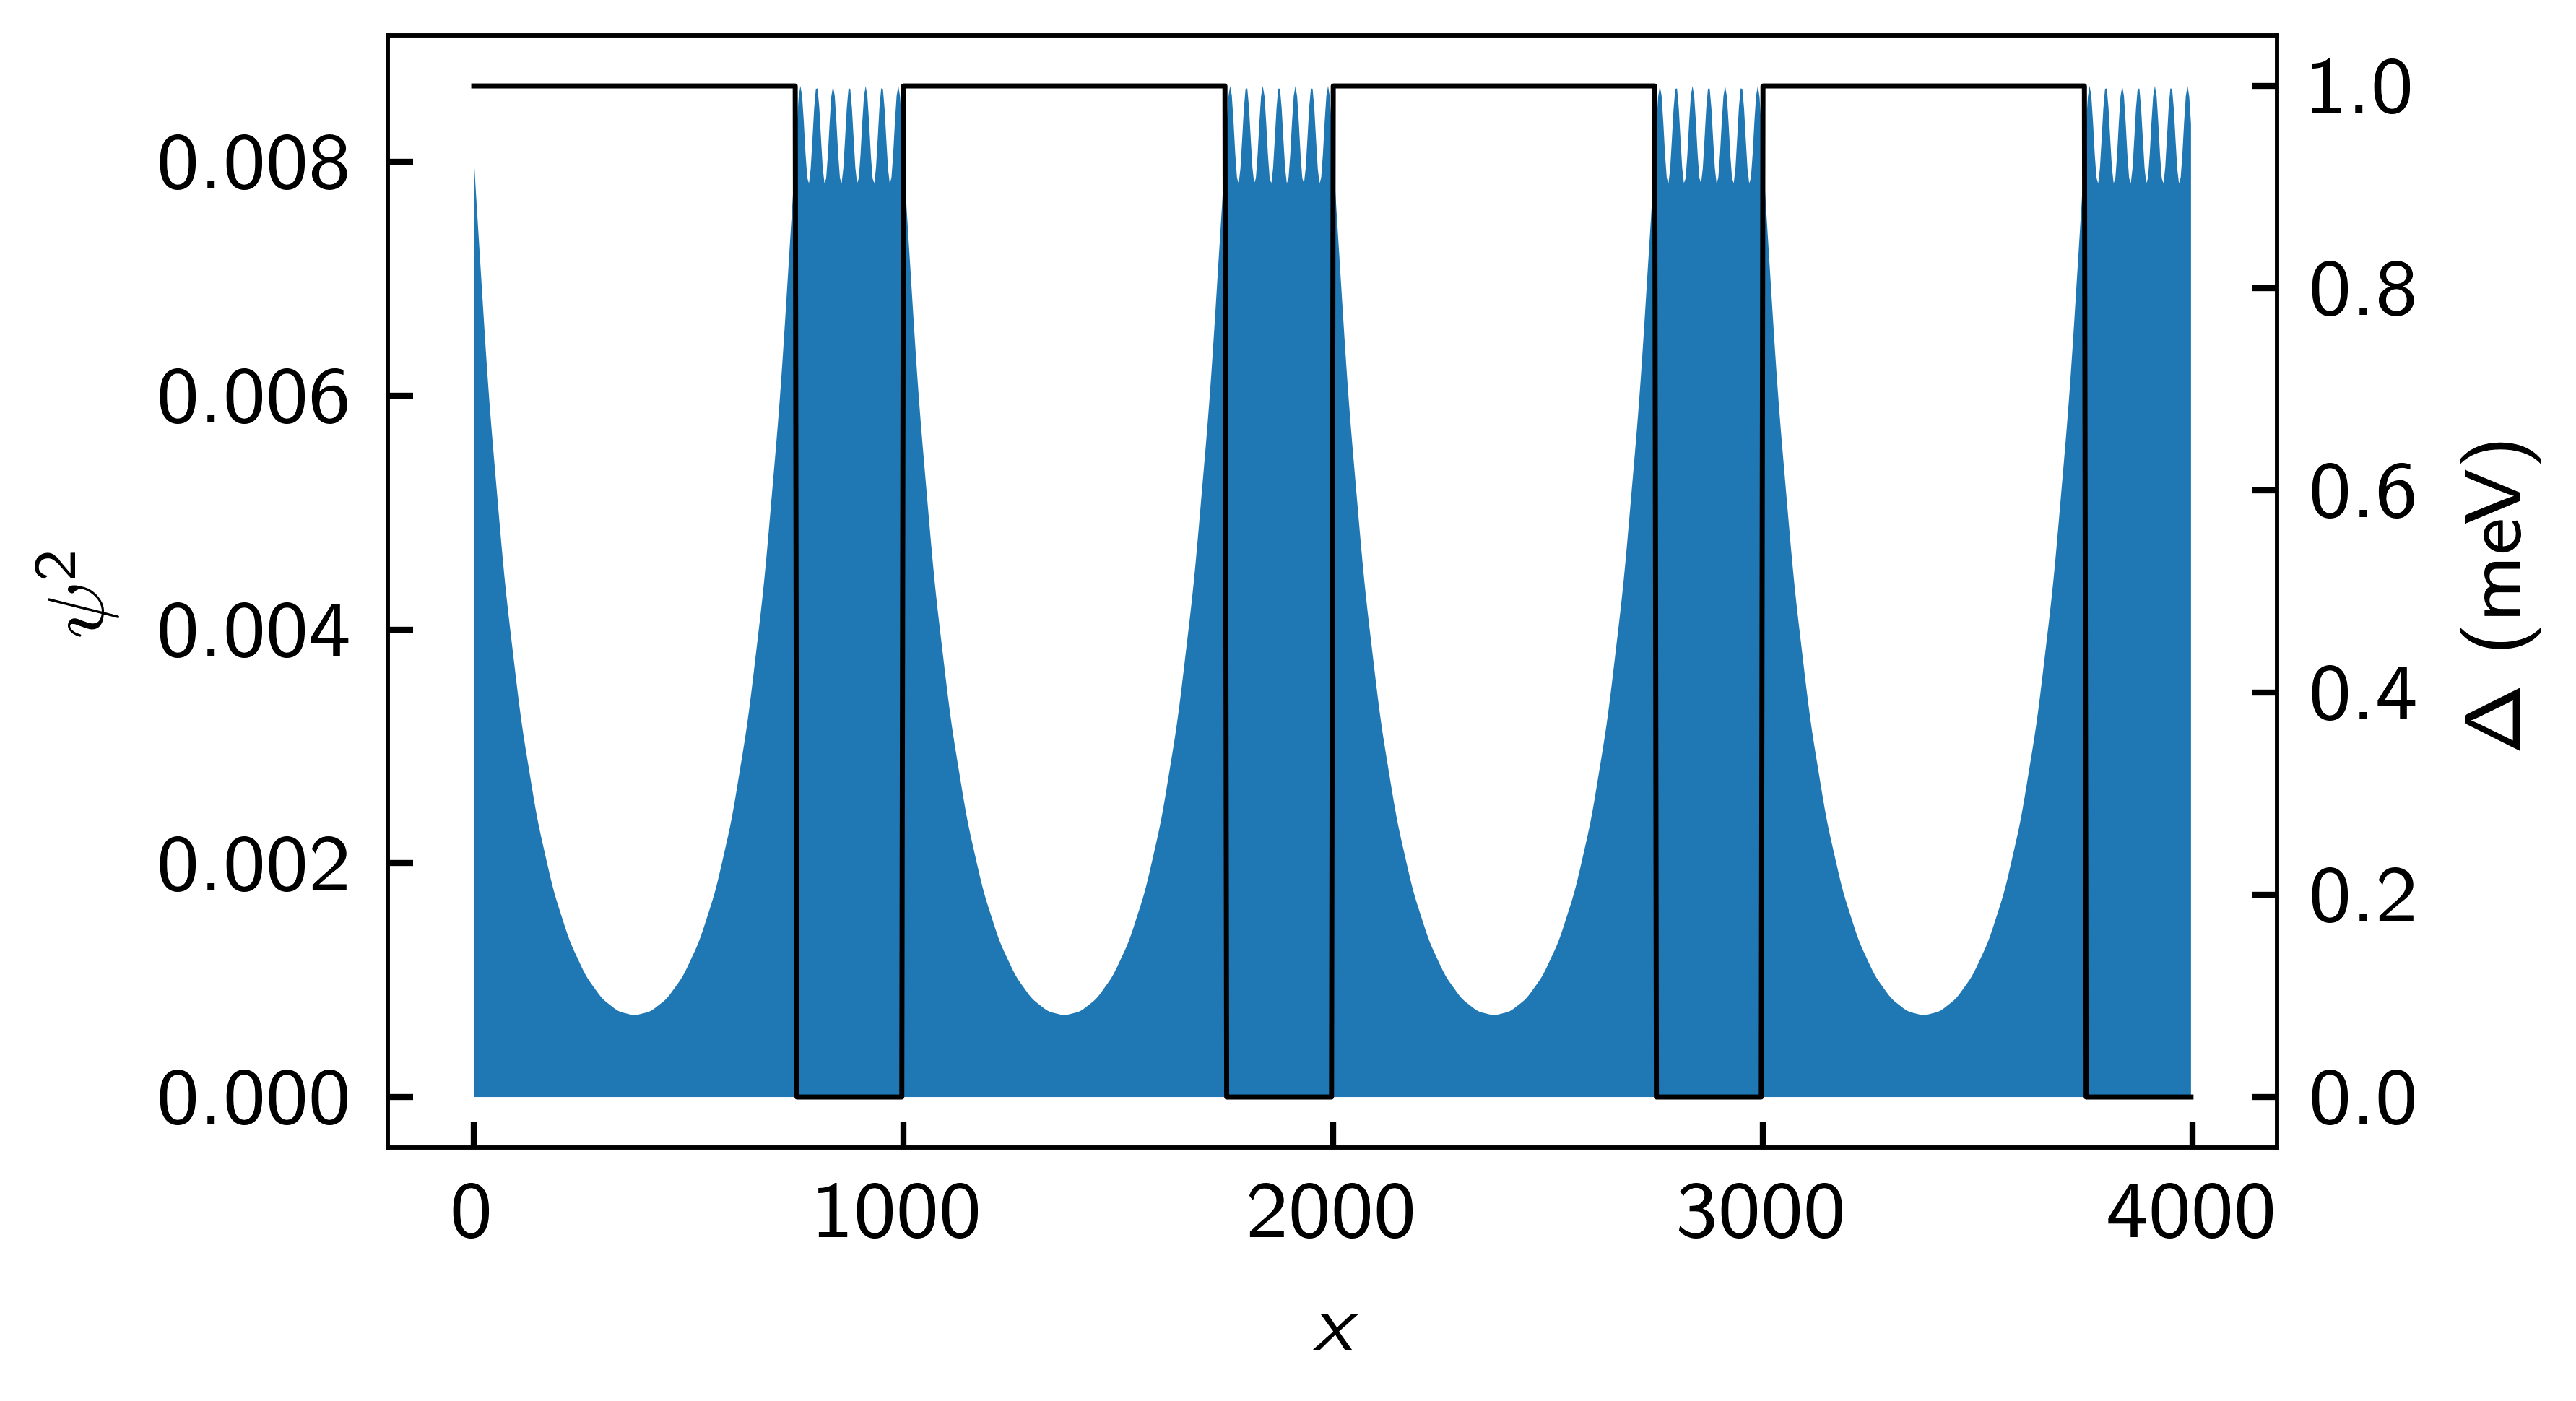

In [22]:
v = vs[k_N//2, phi_N//4, :, Nx] 
v = v.reshape(Nx, 2)
psi2 = np.tile(np.einsum("ab, bc, ac -> a", v.conj(), [[1, 0], [0, 1]], v), 4).real

x2 = np.linspace(0, 4*L, 4*Nx, endpoint=False)

fig, ax = plt.subplots()
ax.fill_between(x2, psi2)
#ax.set_xlim(L//2, 3*L//2)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\psi^2$")


ax2 = ax.twinx()
ax2.plot(x2, np.tile(Delta, 4), '-k')
ax2.set_ylabel(r"$\Delta$ (meV)")

fig.savefig(dir_name+"wf.png")

In [23]:
k_N = 61
k_ax = np.linspace(-np.pi/L, np.pi/L, k_N)
dk = k_ax[1] - k_ax[0]

phi_N = 121
phi_ax = np.linspace(0, 4*np.pi, phi_N)

k, phi = np.meshgrid(k_ax, phi_ax)

In [24]:
ws = np.zeros((k_N, phi_N, 2*Nx))
# vs = np.zeros((k_N, phi_N, 2*Nx, 2*Nx), dtype=complex)

for i, k in tqdm(enumerate(k_ax), total=k_N):
    for j, phi in enumerate(phi_ax):
        ws[i, j], _ = la.eigh(make_H_bind(k, phi))
        # ws[i, j], vs[i, j] = la.eigh(make_H_bind(k, phi))

  0%|          | 0/61 [00:00<?, ?it/s]

In [25]:
e_N = 800
e_ax = np.linspace(-1, 1, e_N)
de = e_ax[1]-e_ax[0]

dos = np.zeros((phi_N, e_N-1))

for j in range(phi_N): 
    for i in range(k_N):
        hist, e = np.histogram(ws[i, j], bins = e_ax)
        dos[j] += hist/de

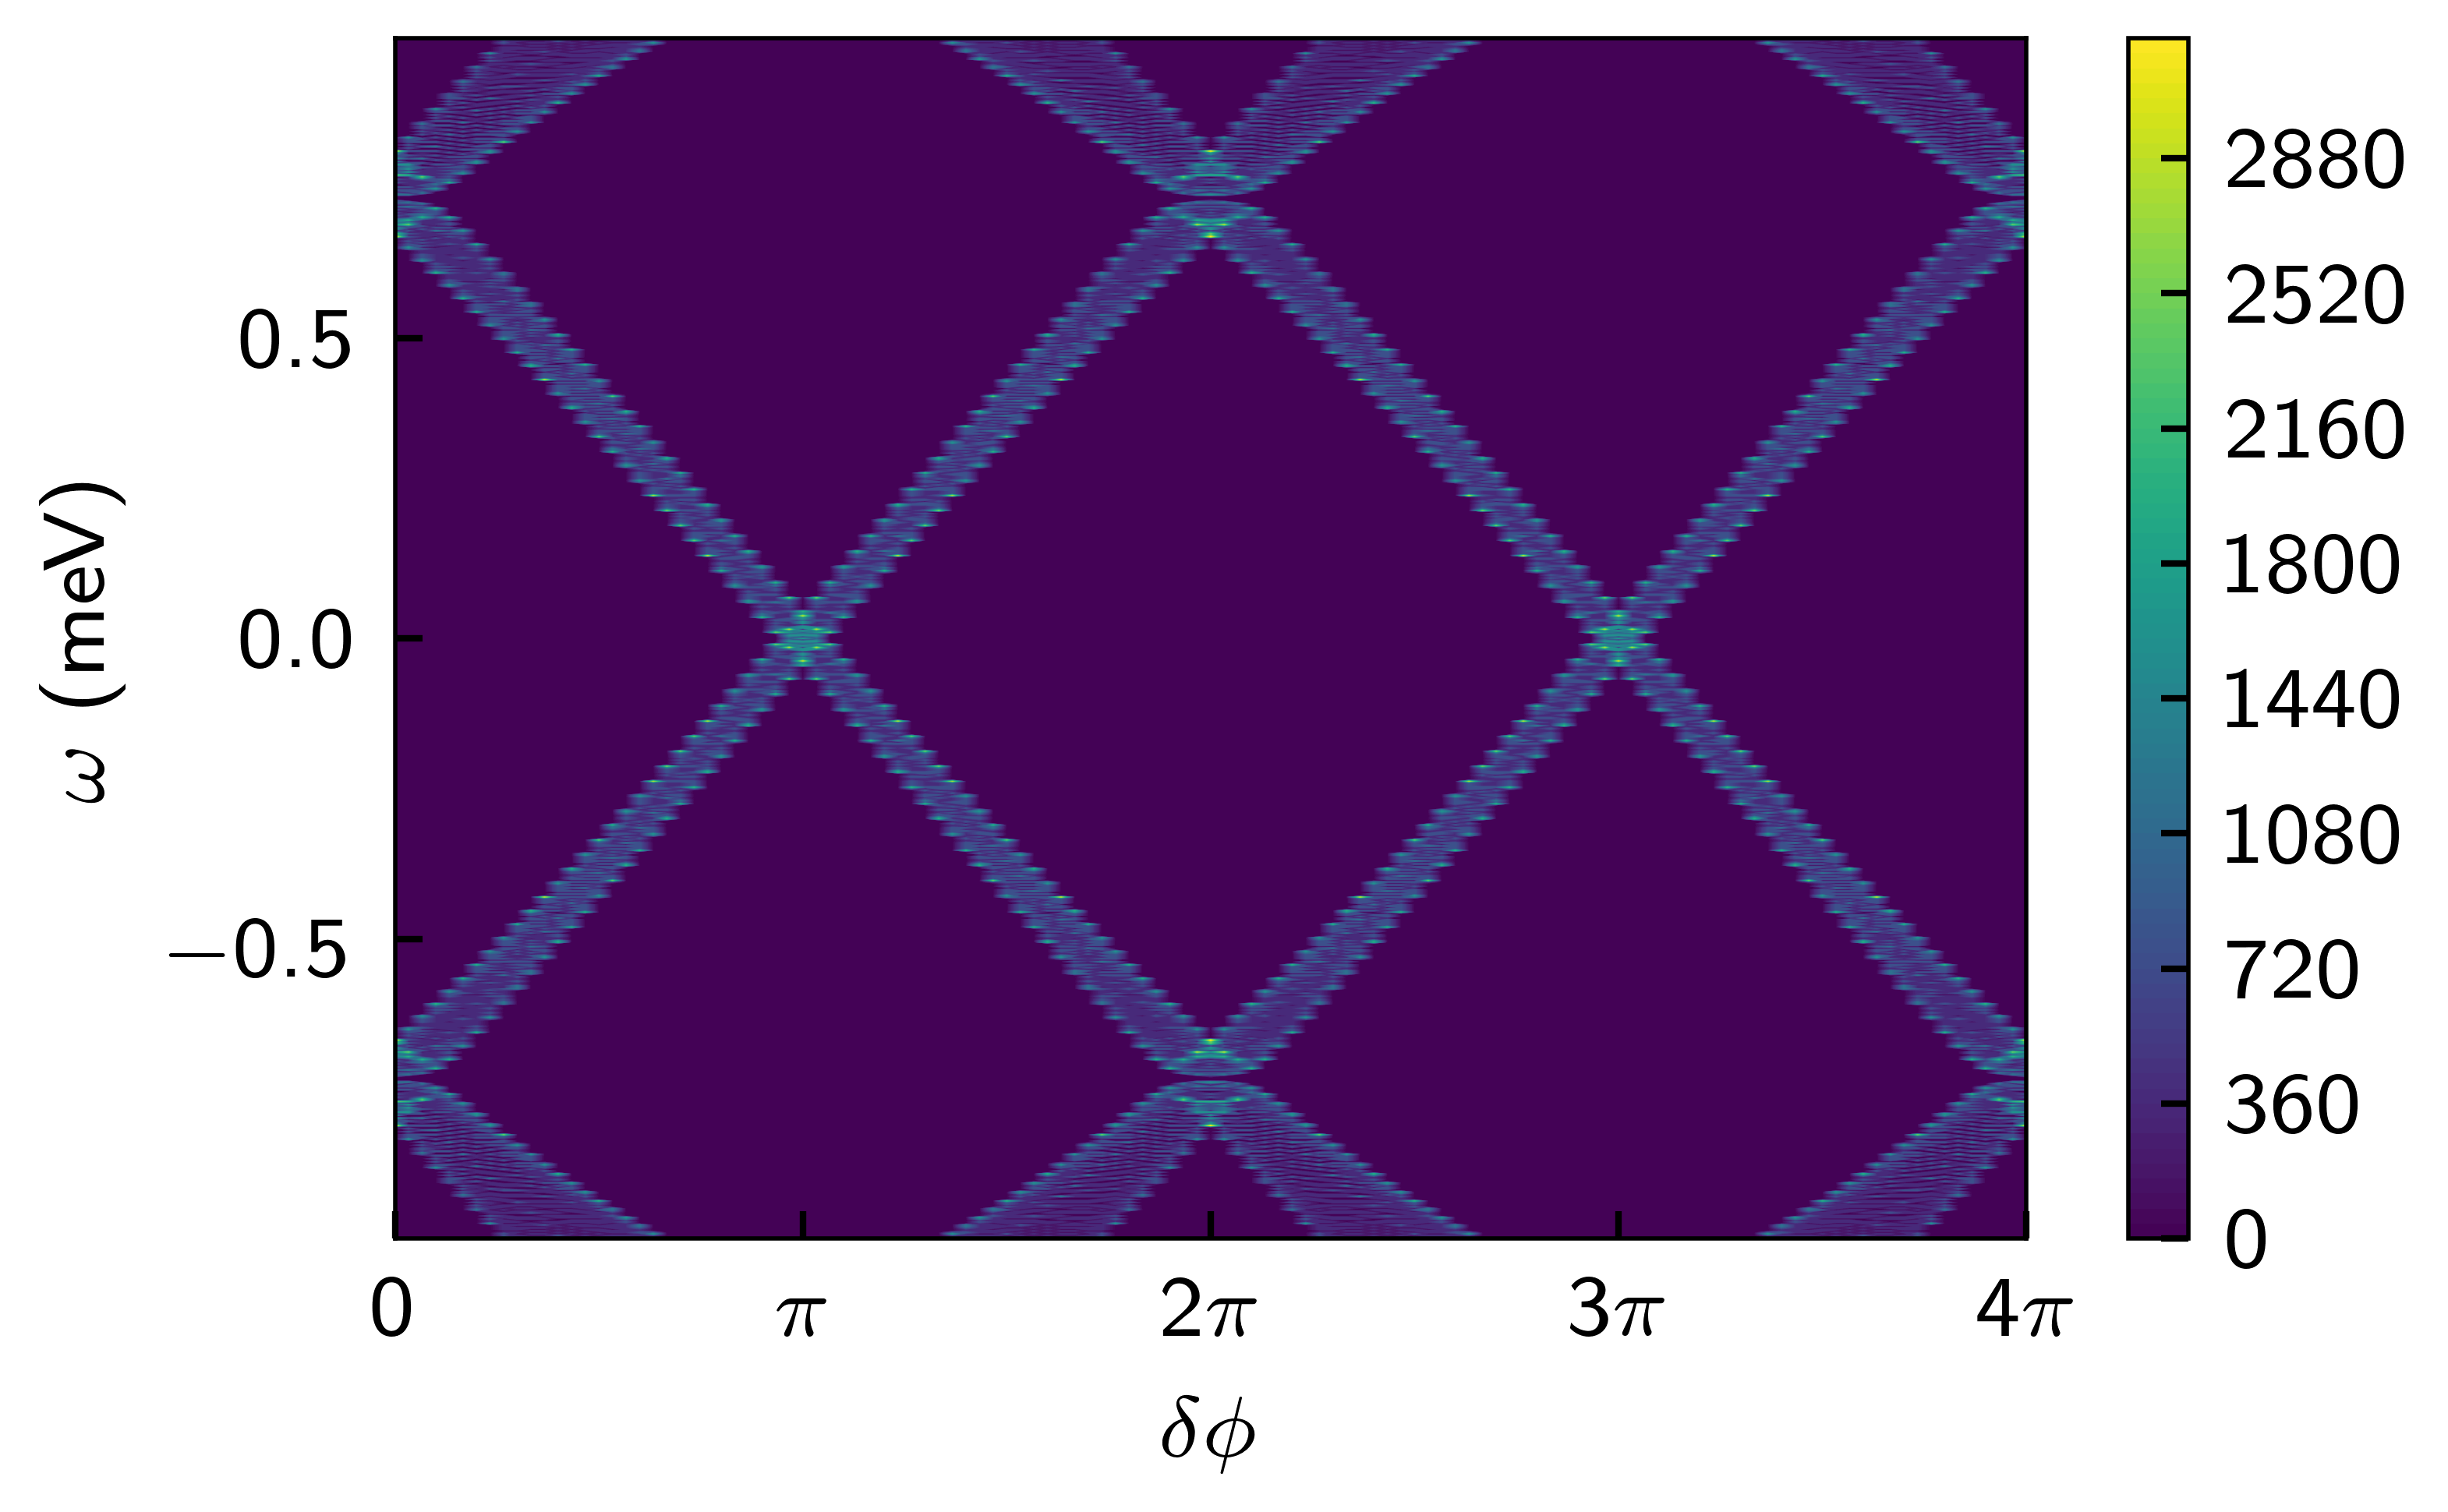

In [26]:
fig, ax = plt.subplots()
im = ax.contourf( phi_ax, e_ax[:-1]+de/2, dos.T, levels=100)
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.set_xlabel(r"$\delta \phi$")

ax.set_ylabel(r"$\omega$ (meV)")
fig.colorbar(im)

fig.savefig(dir_name+"dos_T0.png")

In [27]:
dos_FT = np.zeros_like(dos)
for j in tqdm(range(phi_N), total=phi_N): 
    dos_FT[j] += thermal_broadening(e[1:], dos[j], 0.005
                                   )

  0%|          | 0/121 [00:00<?, ?it/s]

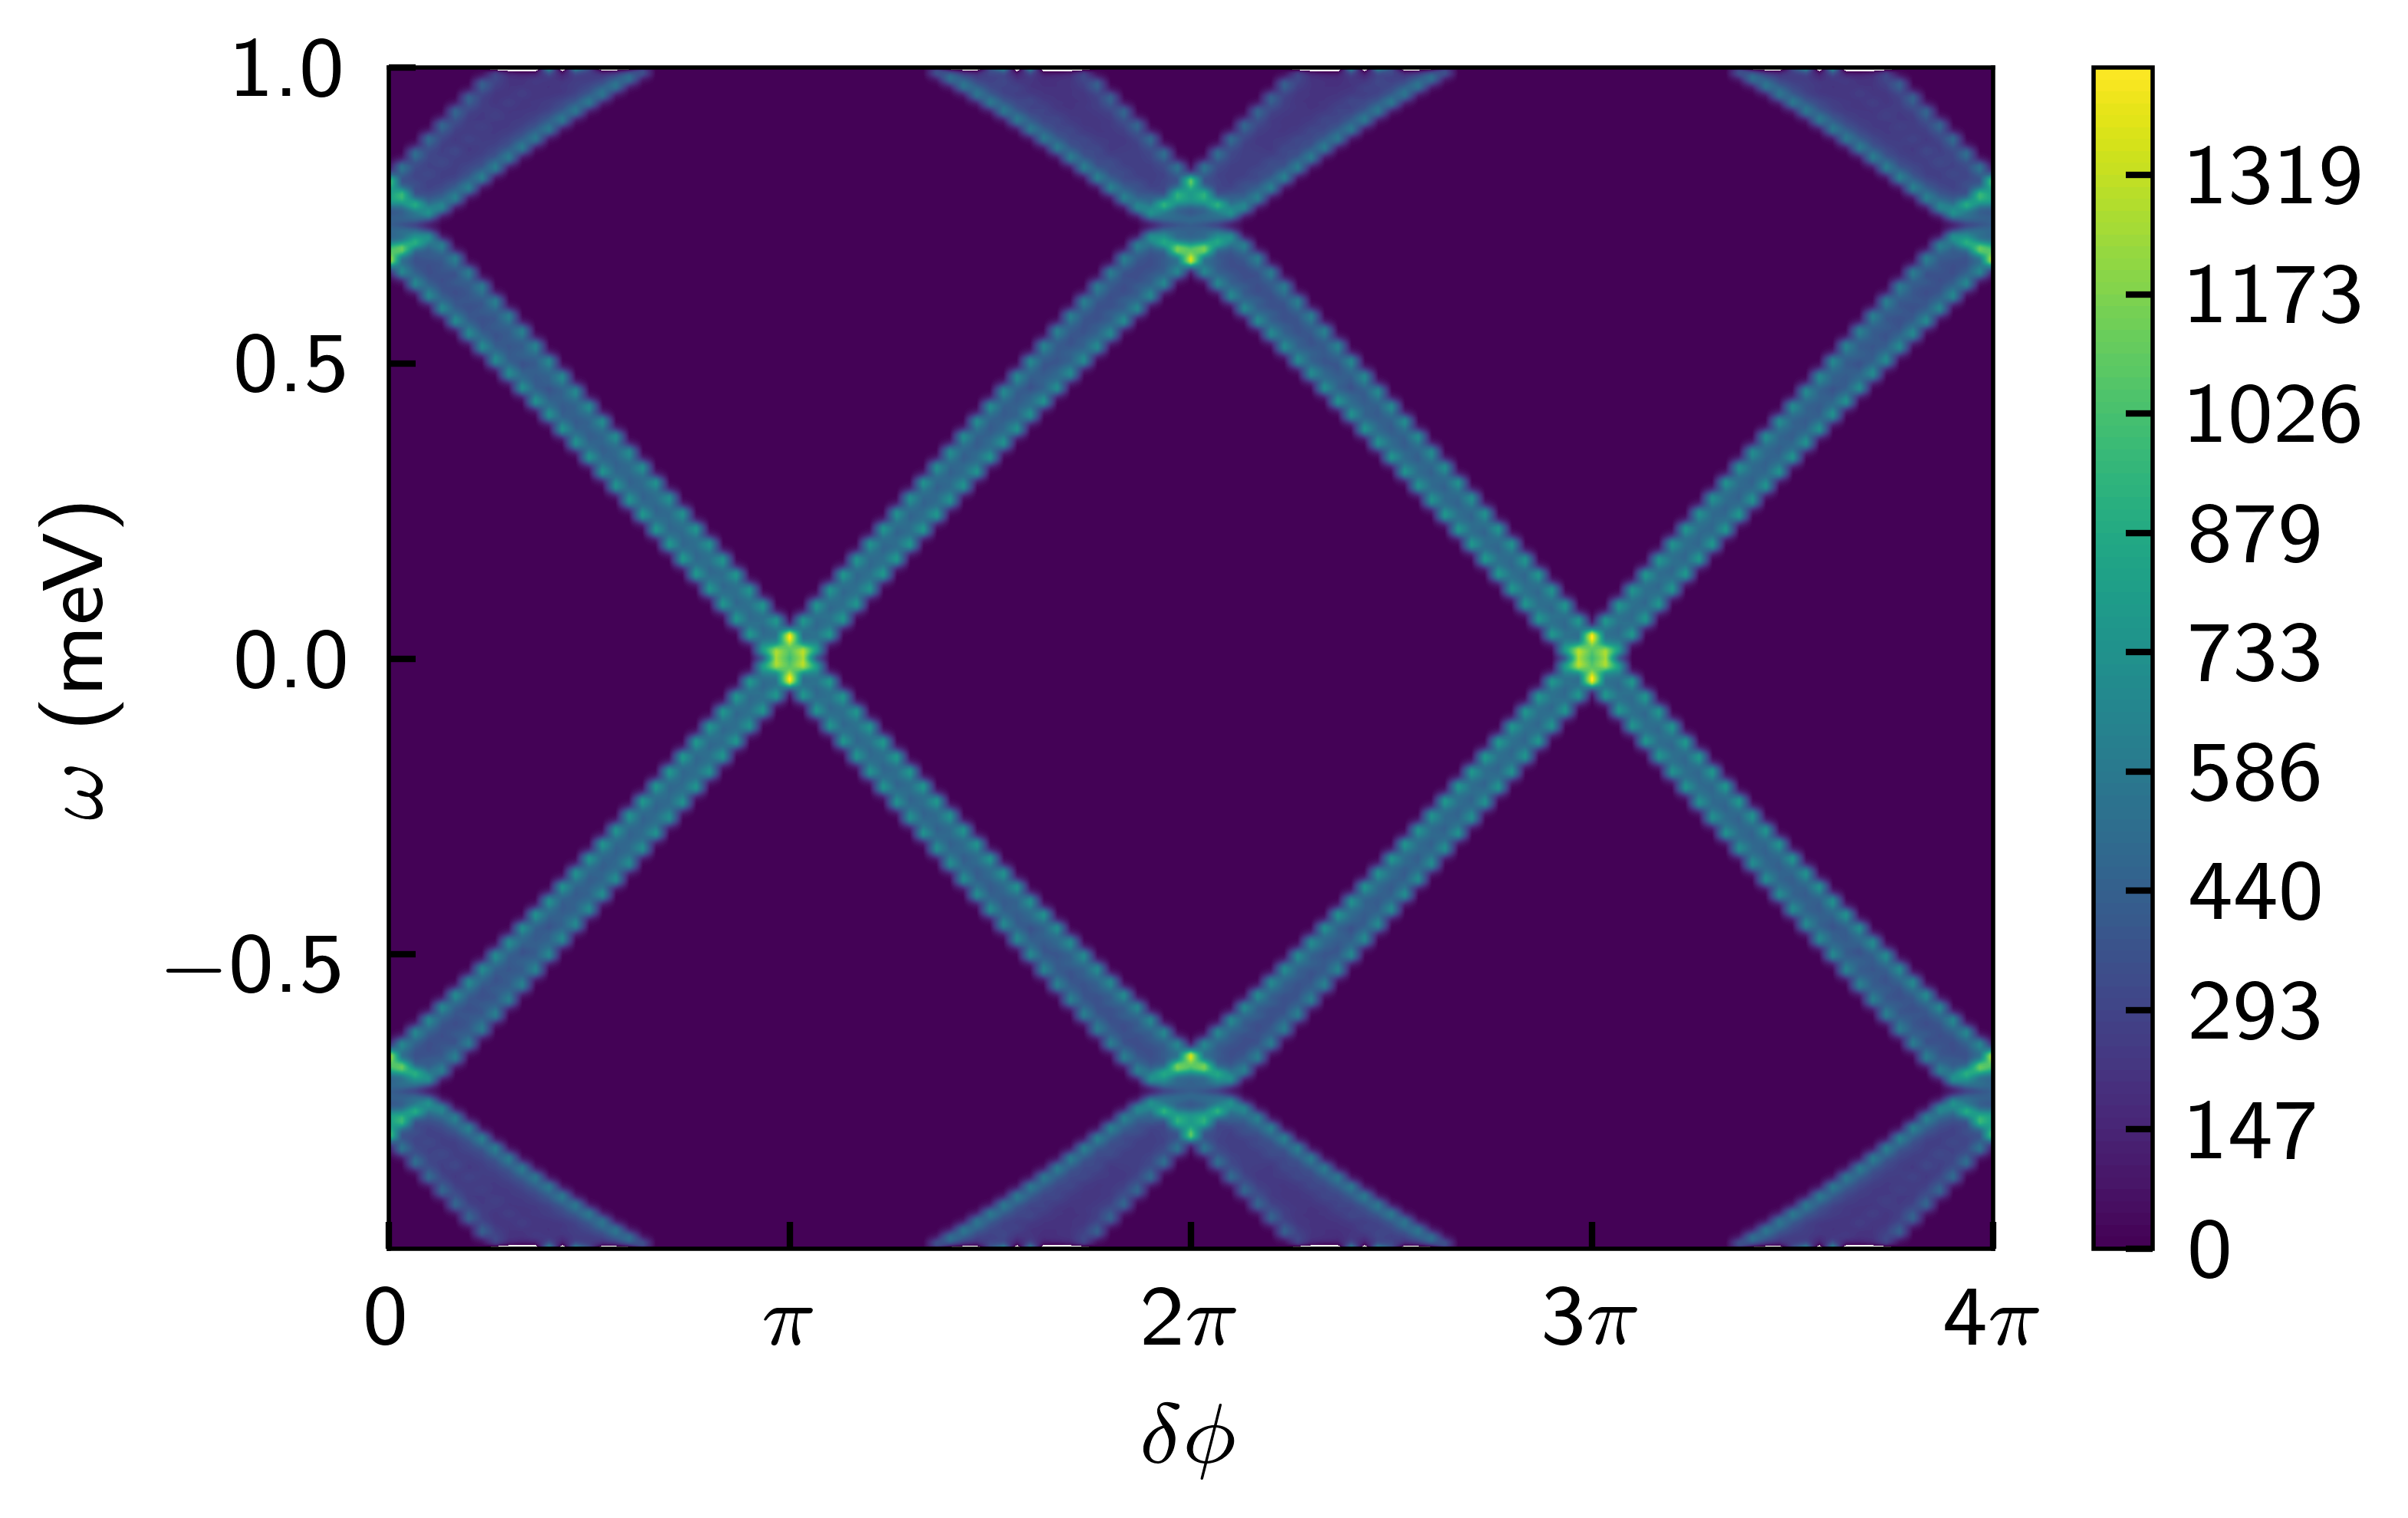

In [28]:
fig, ax = plt.subplots()
im = ax.contourf( phi_ax, e_ax[1:], dos_FT.T, levels=np.linspace(0, dos_FT.max(), 100))
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.set_xlabel(r"$\delta \phi$")
ax.set_ylabel(r"$\omega$ (meV)")
fig.colorbar(im)

fig.savefig(dir_name+"dos_FT.png")

In [29]:
EJ = np.sum(abs(ws), axis = (0, -1))*dk

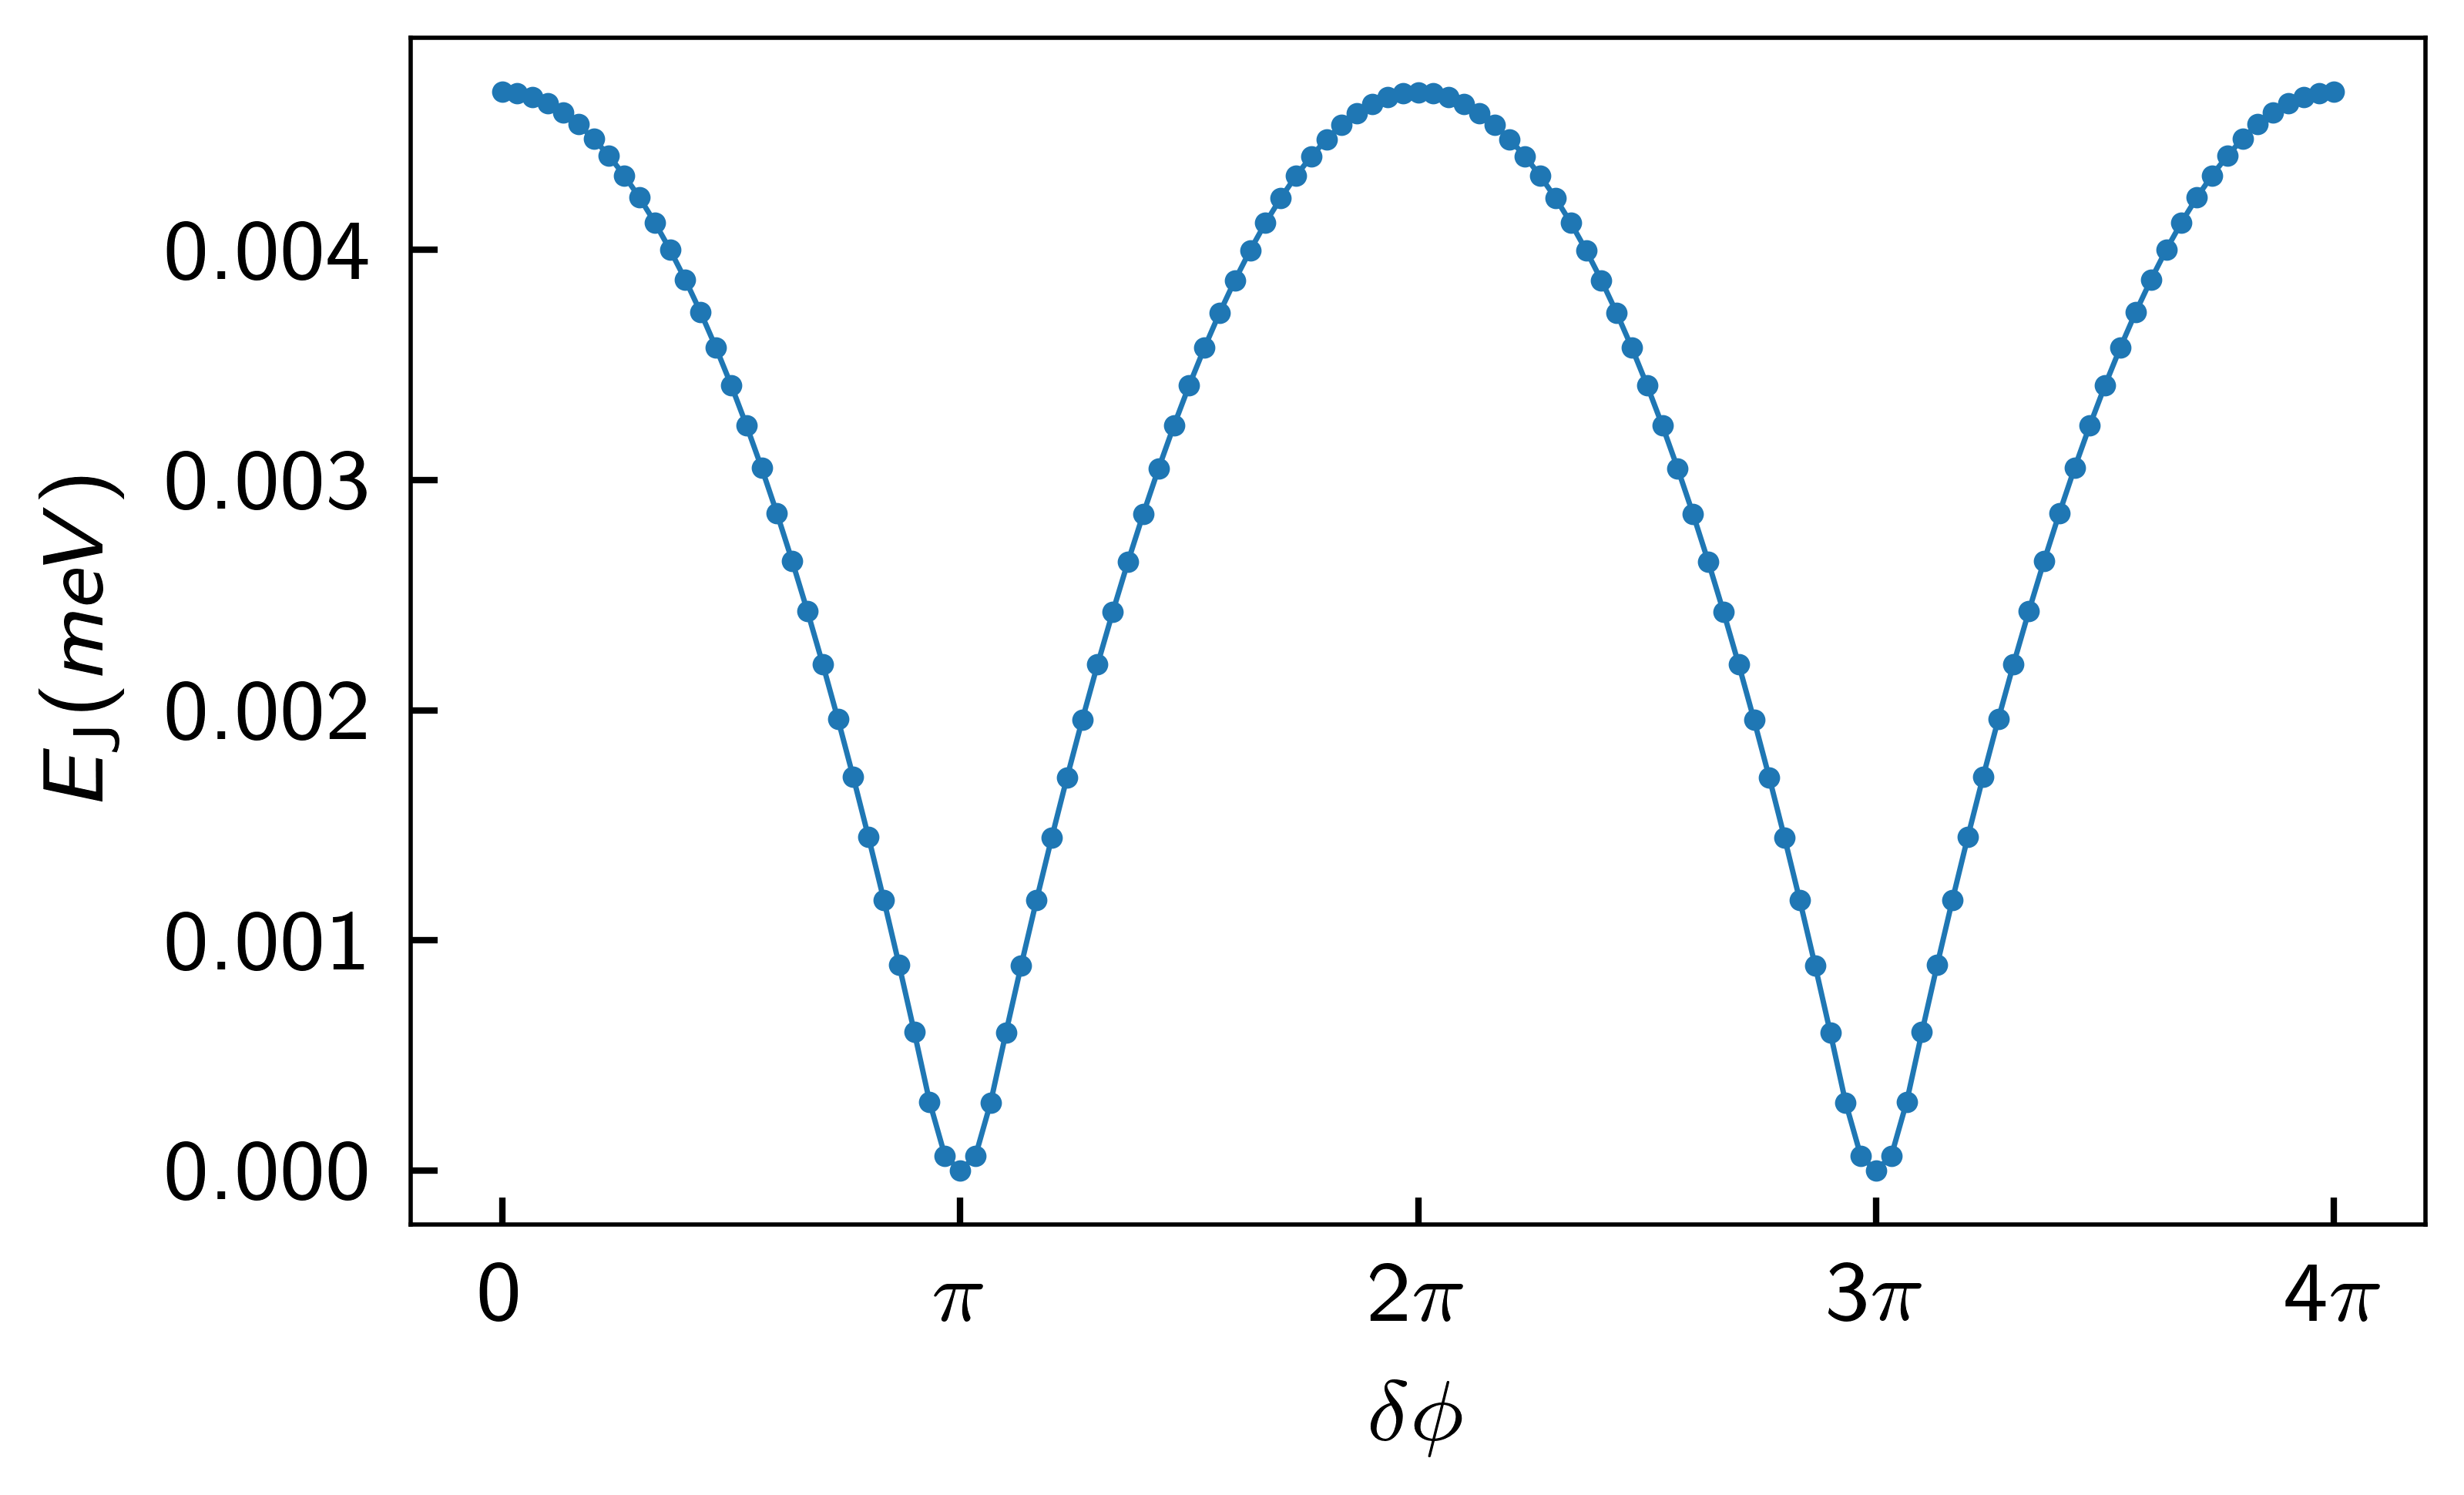

In [30]:
fig, ax = plt.subplots()
ax.plot(phi_ax, EJ - EJ.min())
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.set_xlabel(r"$\delta \phi$")
ax.set_ylabel(r"$E_\mathrm{J} (meV)$")

fig.savefig(dir_name+"JE.png")